# 0. Setup

In [1]:
import kagglehub
data_path = kagglehub.dataset_download('danielagluj/sleep-30s-spectrograms-from-dodh-dataset')

100%|██████████| 463M/463M [00:04<00:00, 101MB/s]

Extracting files...


In [2]:
import shutil
import os

src = data_path
dst = "/content/data"
if not os.path.exists(dst):
    shutil.copytree(src, dst)

In [3]:
!pip install segmentation-models-pytorch albumentations opencv-python scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.1 MB/s eta 0:00:00


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from tqdm import tqdm
import time
import random
seed = 11
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


# 1. EDA

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

TRAIN_PATH = '/content/data/sleep_spectrogram_dataset'
TEST_PATH = '/content/data/test_set_unseen_sub015'

CLASSES = ['W', 'N1', 'N2', 'N3', 'REM']

TRAIN_PATH, TEST_PATH, CLASSES

('/content/data/sleep_spectrogram_dataset',
 '/content/data/test_set_unseen_sub015',
 ['W', 'N1', 'N2', 'N3', 'REM'])

In [7]:
def get_dataset_stats(data_path, classes):
    stats = {
        'class': [],
        'num_images': [],
        'patient_ids': []
    }

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist")
            continue

        files = [f for f in os.listdir(class_path) if f.endswith('.png')]

        patient_ids = set()
        for f in files:
            patient_id = f.split('_')[0]
            patient_ids.add(patient_id)

        stats['class'].append(cls)
        stats['num_images'].append(len(files))
        stats['patient_ids'].append(patient_ids)

    df = pd.DataFrame({
        'class': stats['class'],
        'num_images': stats['num_images'],
        'num_patients': [len(pids) for pids in stats['patient_ids']]
    })

    return df, stats['patient_ids']

train_stats, train_patient_ids = get_dataset_stats(TRAIN_PATH, CLASSES)
print(train_stats)
print(f"\nTotal training images: {train_stats['num_images'].sum()}")
print(f"Total unique patients in train: {len(set.union(*train_patient_ids))}")

test_stats, test_patient_ids = get_dataset_stats(TEST_PATH, CLASSES)
print(test_stats)
print(f"\nTotal test images: {test_stats['num_images'].sum()}")
print(f"Total unique patients in test: {len(set.union(*test_patient_ids))}")

train_patients = set.union(*train_patient_ids)
test_patients = set.union(*test_patient_ids)
overlap = train_patients.intersection(test_patients)
print(f"\nPatient overlap between train and test: {overlap}")
if len(overlap) == 0:
    print("No patient leakage detected")
else:
    print("Patient leakage")

  class  num_images  num_patients
0     W        1008             5
1    N1         317             5
2    N2        2047             5
3    N3         523             5
4   REM         754             5

Total training images: 4649
Total unique patients in train: 5
  class  num_images  num_patients
0     W          57             1
1    N1          58             1
2    N2         409             1
3    N3         144             1
4   REM         261             1

Total test images: 929
Total unique patients in test: 1

Patient overlap between train and test: set()
No patient leakage detected


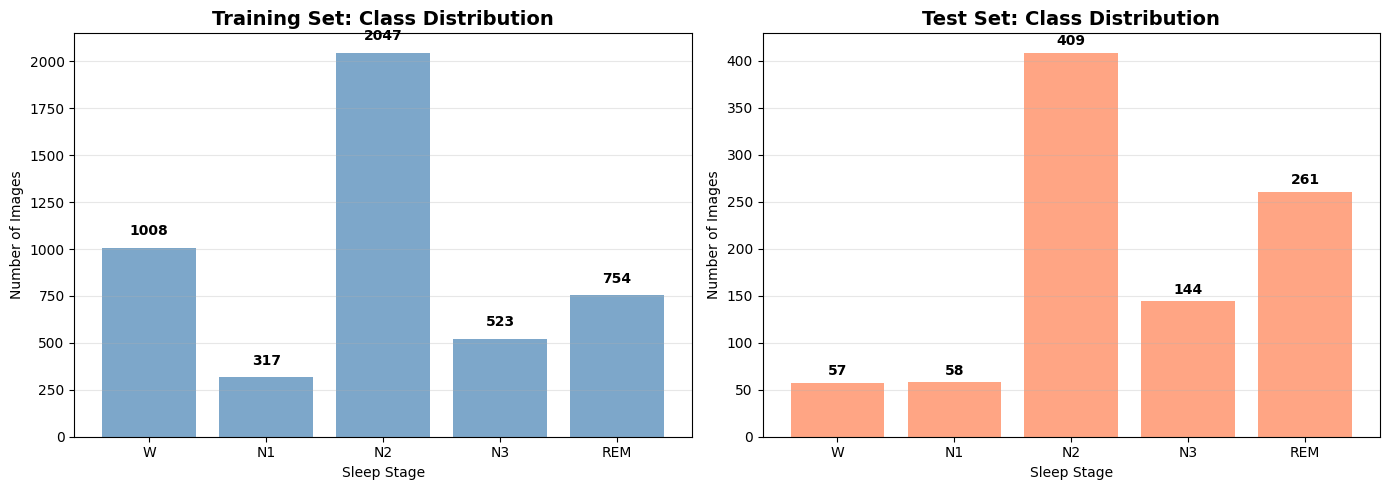


Class imbalance ratio (max/min): 6.46
Significant class imbalance detected - consider using class weights or resampling


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(train_stats['class'], train_stats['num_images'], color='steelblue', alpha=0.7)
axes[0].set_title('Training Set: Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sleep Stage')
axes[0].set_ylabel('Number of Images')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(train_stats['num_images']):
    axes[0].text(i, v + 50, str(v), ha='center', va='bottom', fontweight='bold')

axes[1].bar(test_stats['class'], test_stats['num_images'], color='coral', alpha=0.7)
axes[1].set_title('Test Set: Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sleep Stage')
axes[1].set_ylabel('Number of Images')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(test_stats['num_images']):
    axes[1].text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

imbalance_ratio = train_stats['num_images'].max() / train_stats['num_images'].min()
print(f"\nClass imbalance ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("Significant class imbalance detected - consider using class weights or resampling")

In [9]:
def get_patient_epoch_distribution(data_path, classes):
    patient_epoch_count = {}

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith('.png')]

        for f in files:
            patient_id = f.split('_')[0]
            if patient_id not in patient_epoch_count:
                patient_epoch_count[patient_id] = 0
            patient_epoch_count[patient_id] += 1

    return patient_epoch_count

train_patient_dist = get_patient_epoch_distribution(TRAIN_PATH, CLASSES)
test_patient_dist = get_patient_epoch_distribution(TEST_PATH, CLASSES)

print("PATIENT EPOCH DISTRIBUTION (TRAIN)")
for patient, count in sorted(train_patient_dist.items()):
    print(f"{patient}: {count} epochs")

print(f"\nAverage epochs per patient (train): {np.mean(list(train_patient_dist.values())):.1f}")
print(f"Min epochs per patient (train): {np.min(list(train_patient_dist.values()))}")
print(f"Max epochs per patient (train): {np.max(list(train_patient_dist.values()))}")

print("\nPATIENT EPOCH DISTRIBUTION (TEST)")
for patient, count in sorted(test_patient_dist.items()):
    print(f"{patient}: {count} epochs")

PATIENT EPOCH DISTRIBUTION (TRAIN)
Sub003: 986 epochs
Sub004: 620 epochs
Sub008: 969 epochs
Sub010: 1063 epochs
Sub011: 1011 epochs

Average epochs per patient (train): 929.8
Min epochs per patient (train): 620
Max epochs per patient (train): 1063

PATIENT EPOCH DISTRIBUTION (TEST)
Sub015: 929 epochs


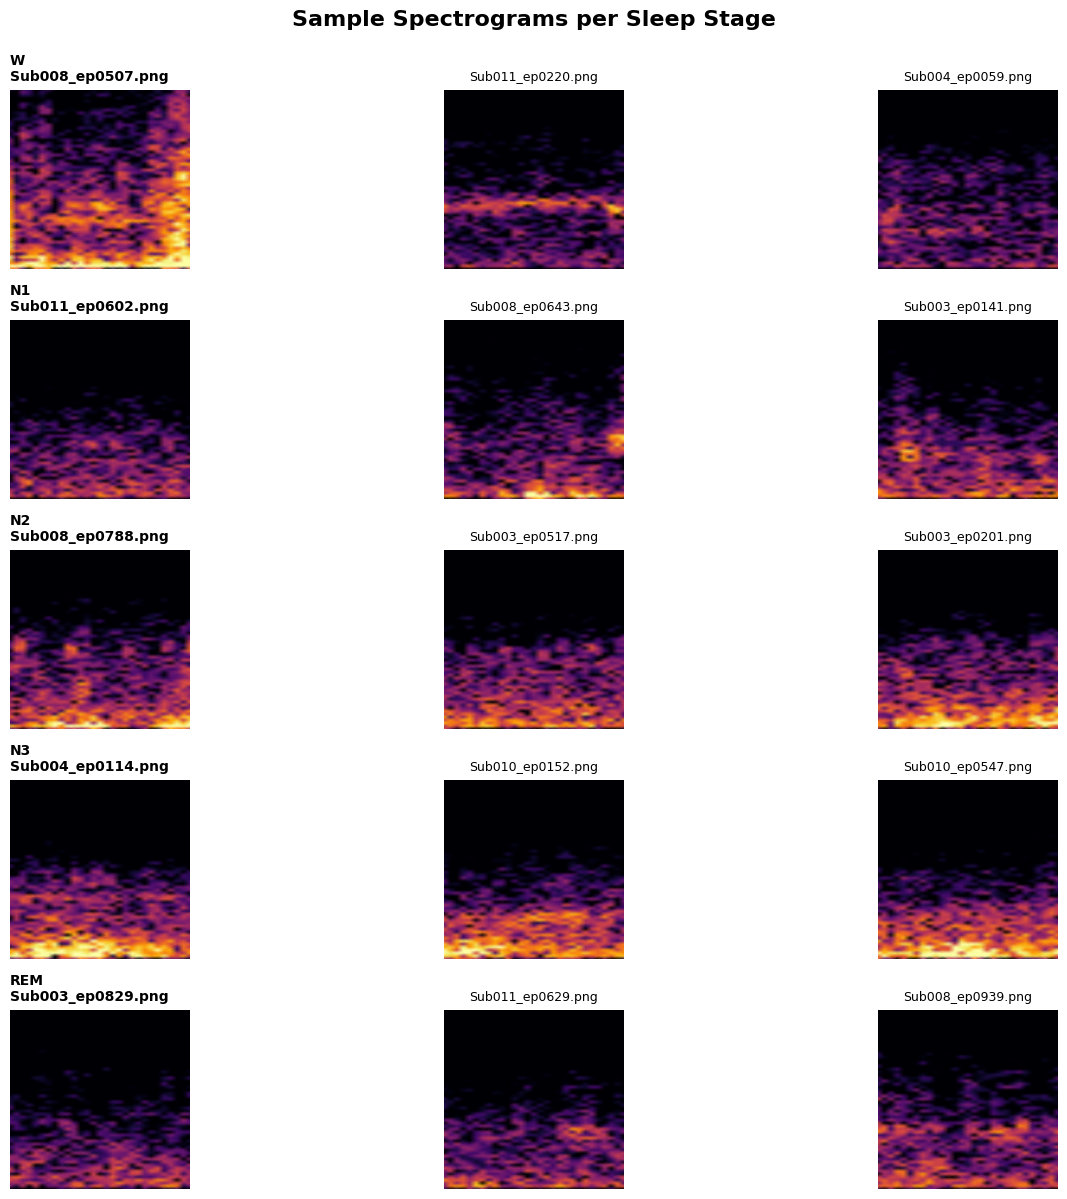

In [10]:
def visualize_samples(data_path, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 12))

    for i, cls in enumerate(classes):
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        selected_files = np.random.choice(files, min(num_samples, len(files)), replace=False)

        for j, file in enumerate(selected_files):
            img_path = os.path.join(class_path, file)
            img = Image.open(img_path)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_title(f'{cls}\n{file}', fontsize=10, fontweight='bold', loc='left')
            else:
                axes[i, j].set_title(file, fontsize=9)

    plt.suptitle('Sample Spectrograms per Sleep Stage', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

visualize_samples(TRAIN_PATH, CLASSES, num_samples=3)

In [11]:
def analyze_image_properties(data_path, classes, num_samples=10):
    properties = {
        'shapes': [],
        'dtypes': [],
        'mean_values': [],
        'std_values': []
    }

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        selected_files = np.random.choice(files, min(num_samples, len(files)), replace=False)

        for file in selected_files:
            img_path = os.path.join(class_path, file)
            img = np.array(Image.open(img_path))

            properties['shapes'].append(img.shape)
            properties['dtypes'].append(img.dtype)
            properties['mean_values'].append(img.mean())
            properties['std_values'].append(img.std())

    return properties

props = analyze_image_properties(TRAIN_PATH, CLASSES, num_samples=10)

print(f"Unique shapes: {set(props['shapes'])}")
print(f"Unique dtypes: {set(props['dtypes'])}")
print(f"Mean pixel value (avg): {np.mean(props['mean_values']):.2f}")
print(f"Std pixel value (avg): {np.mean(props['std_values']):.2f}")
print(f"Min mean across images: {np.min(props['mean_values']):.2f}")
print(f"Max mean across images: {np.max(props['mean_values']):.2f}")

Unique shapes: {(300, 300, 4)}
Unique dtypes: {dtype('uint8')}
Mean pixel value (avg): 92.93
Std pixel value (avg): 103.72
Min mean across images: 83.33
Max mean across images: 137.12


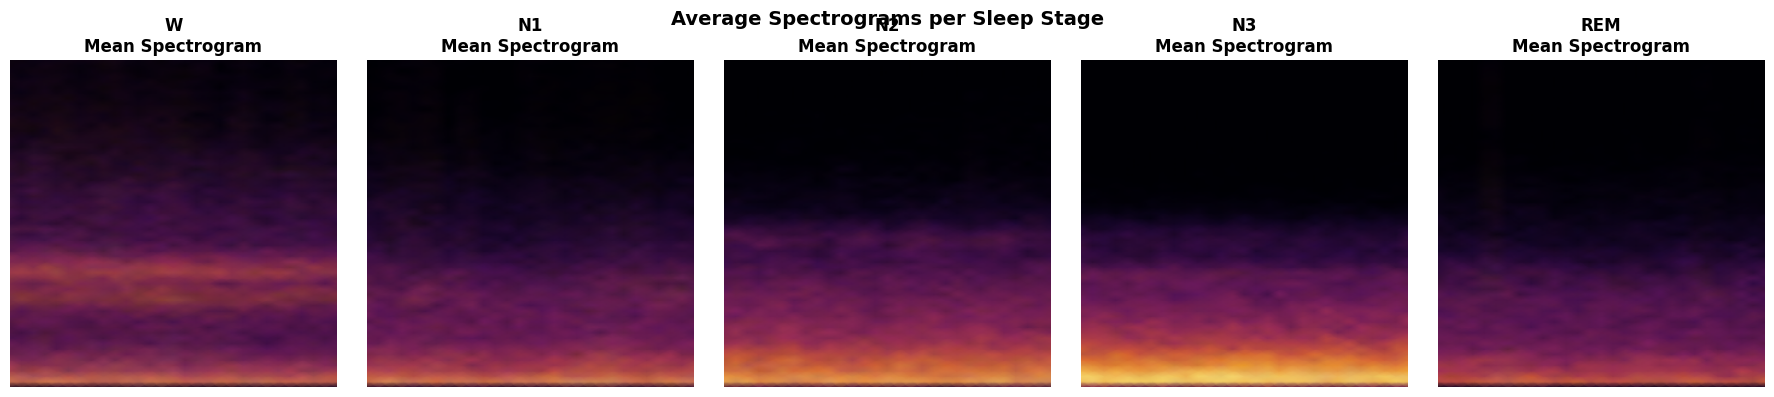

In [12]:
def compute_mean_spectrogram(data_path, classes, num_samples=50):
    mean_spectrograms = {}

    for cls in classes:
        class_path = os.path.join(data_path, cls)
        if not os.path.exists(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        selected_files = np.random.choice(files, min(num_samples, len(files)), replace=False)

        images = []
        for file in selected_files:
            img_path = os.path.join(class_path, file)
            img = np.array(Image.open(img_path)).astype(np.float32)
            images.append(img)

        mean_spectrograms[cls] = np.mean(images, axis=0)

    return mean_spectrograms

mean_specs = compute_mean_spectrogram(TRAIN_PATH, CLASSES, num_samples=50)

fig, axes = plt.subplots(1, len(CLASSES), figsize=(18, 4))

for i, cls in enumerate(CLASSES):
    if cls in mean_specs:
        axes[i].imshow(mean_specs[cls].astype(np.uint8))
        axes[i].set_title(f'{cls}\nMean Spectrogram', fontweight='bold')
        axes[i].axis('off')

plt.suptitle('Average Spectrograms per Sleep Stage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
print(f"   Total training images: {train_stats['num_images'].sum()}")
print(f"   Total test images: {test_stats['num_images'].sum()}")
print(f"   Number of classes: {len(CLASSES)}")
print(f"   Classes: {CLASSES}")

print(f"   Unique patients in train: {len(set.union(*train_patient_ids))}")
print(f"   Unique patients in test: {len(set.union(*test_patient_ids))}")
print(f"   Patient leakage: {'No' if len(train_patients.intersection(test_patients)) == 0 else 'Yes'}")

print(train_stats[['class', 'num_images']].to_string(index=False))
imb_ratio = train_stats['num_images'].max() / train_stats['num_images'].min()
print(f"   Imbalance ratio: {imb_ratio:.2f}")

print(f"   Shape: {list(set(props['shapes']))[0]}")
print(f"   Dtype: {list(set(props['dtypes']))[0]}")
print(f"   Pixel value range: ~0-255")

if imb_ratio > 3:
    print("- Use class weights due to imbalance")
else:
    print("- Class balance is acceptable")

   Total training images: 4649
   Total test images: 929
   Number of classes: 5
   Classes: ['W', 'N1', 'N2', 'N3', 'REM']
   Unique patients in train: 5
   Unique patients in test: 1
   Patient leakage: No
class  num_images
    W        1008
   N1         317
   N2        2047
   N3         523
  REM         754
   Imbalance ratio: 6.46
   Shape: (300, 300, 4)
   Dtype: uint8
   Pixel value range: ~0-255
- Use class weights due to imbalance


# Dataset handling

In [14]:
class SleepSpectrogramDataset(Dataset):
    def __init__(self, data_path, classes, transform=None):
        self.data_path = data_path
        self.classes = classes
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        self.samples = []
        for cls in classes:
            class_path = os.path.join(data_path, cls)
            if not os.path.exists(class_path):
                continue

            files = [f for f in os.listdir(class_path) if f.endswith('.png')]
            for f in files:
                self.samples.append((os.path.join(class_path, f), self.class_to_idx[cls]))

        print(f"Loaded {len(self.samples)} samples from {data_path}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        img = Image.open(img_path)

        if img.mode == 'RGBA':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# Augmentation (ImageNet not flip)

In [15]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data loader

In [16]:
train_dataset = SleepSpectrogramDataset(TRAIN_PATH, CLASSES, transform=train_transform)
test_dataset = SleepSpectrogramDataset(TEST_PATH, CLASSES, transform=test_transform)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

class_counts = train_stats['num_images'].values
total_samples = sum(class_counts)
class_weights = torch.FloatTensor([total_samples / (len(class_counts) * count) for count in class_counts])
class_weights = class_weights.to(device)

print(f"\nClass weights (to handle imbalance):")
for i, cls in enumerate(CLASSES):
    print(f"  {cls}: {class_weights[i]:.3f}")

Loaded 4649 samples from /content/data/sleep_spectrogram_dataset
Loaded 929 samples from /content/data/test_set_unseen_sub015
Train batches: 146
Test batches: 30

Class weights (to handle imbalance):
  W: 0.922
  N1: 2.933
  N2: 0.454
  N3: 1.778
  REM: 1.233


# Model

## Custom CNN

In [17]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_custom = CustomCNN(num_classes=len(CLASSES))
total_params = sum(p.numel() for p in model_custom.parameters())
trainable_params = sum(p.numel() for p in model_custom.parameters() if p.requires_grad)

print(f"Custom CNN Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / (1024**2):.2f} MB")

Custom CNN Architecture:
Total parameters: 1,703,173
Trainable parameters: 1,703,173
Model size: ~6.50 MB


## Pretrained models

In [18]:
def create_resnet18(num_classes=5, pretrained=True):
    model = models.resnet18(pretrained=pretrained)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def create_efficientnet_b0(num_classes=5, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

def create_mobilenet_v2(num_classes=5, pretrained=True):
    model = models.mobilenet_v2(pretrained=pretrained)
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    return model

model_resnet = create_resnet18(num_classes=len(CLASSES), pretrained=True)
model_efficientnet = create_efficientnet_b0(num_classes=len(CLASSES), pretrained=True)
model_mobilenet = create_mobilenet_v2(num_classes=len(CLASSES), pretrained=True)

print("Transfer Learning Models Created:")
print(f"1. ResNet18 (pretrained on ImageNet)")
print(f"2. EfficientNet-B0 (pretrained on ImageNet)")
print(f"3. MobileNetV2 (pretrained on ImageNet)")

for name, model in [("ResNet18", model_resnet), ("EfficientNet-B0", model_efficientnet), ("MobileNetV2", model_mobilenet)]:
    total = sum(p.numel() for p in model.parameters())
    print(f"{name}: {total:,} parameters")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 84.5MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 120MB/s]

Transfer Learning Models Created:
1. ResNet18 (pretrained on ImageNet)
2. EfficientNet-B0 (pretrained on ImageNet)
3. MobileNetV2 (pretrained on ImageNet)
ResNet18: 11,179,077 parameters
EfficientNet-B0: 4,013,953 parameters
MobileNetV2: 2,230,277 parameters


# Train + val

In [19]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(test_loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': running_loss/len(pbar), 'acc': 100.*correct/total})

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training and validation functions defined")

Training and validation functions defined


In [20]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [21]:
def train_model_with_early_stopping(model, model_name, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device, patience=7):

    early_stopping = EarlyStopping(patience=patience, min_delta=0.001, verbose=True)

    best_acc = 0.0
    best_epoch = 0
    train_history = {'loss': [], 'acc': []}
    val_history = {'loss': [], 'acc': []}

    print(f"\nTraining {model_name}")
    print("="*60)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_labels = validate(model, test_loader, criterion, device)

        train_history['loss'].append(train_loss)
        train_history['acc'].append(train_acc)
        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)

        if scheduler:
            scheduler.step()

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f'/content/{model_name}_best.pth')
            print(f"Best model saved! Val Acc: {best_acc:.2f}%")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

    print("\n" + "="*60)
    print(f"Training completed for {model_name}")
    print(f"Best Val Acc: {best_acc:.2f}% at epoch {best_epoch}")
    if early_stopping.early_stop:
        print(f"Stopped early after {epoch+1} epochs (patience={patience})")

    return train_history, val_history, best_acc

print("Training loop with early stopping defined")

Training loop with early stopping defined


# Eval

In [22]:
def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    print(f"\n{'='*60}")
    print(f"Evaluation Results: {model_name}")
    print(f"{'='*60}\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASSES, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    kappa = cohen_kappa_score(all_labels, all_preds)
    print(f"\nCohen's Kappa Score: {kappa:.4f}")

    accuracy = (all_preds == all_labels).mean() * 100
    print(f"Overall Accuracy: {accuracy:.2f}%")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'/content/{model_name}_confusion_matrix.png', dpi=150)
    plt.show()

    return {
        'predictions': all_preds,
        'labels': all_labels,
        'accuracy': accuracy,
        'kappa': kappa,
        'confusion_matrix': cm
    }

print("Evaluation function defined")

Evaluation function defined


# Start

### Custom

In [23]:
NUM_EPOCHS = 3000
LEARNING_RATE = 0.001
PATIENCE = 7

model_custom = CustomCNN(num_classes=len(CLASSES)).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_custom = optim.Adam(model_custom.parameters(), lr=LEARNING_RATE)
scheduler_custom = optim.lr_scheduler.StepLR(optimizer_custom, step_size=10, gamma=0.1)

train_hist_custom, val_hist_custom, best_acc_custom = train_model_with_early_stopping(
    model=model_custom,
    model_name="CustomCNN",
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_custom,
    scheduler=scheduler_custom,
    num_epochs=NUM_EPOCHS,
    device=device,
    patience=PATIENCE
)


Training CustomCNN

Epoch 1/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.32it/s, loss=0.958, acc=60.4]


Train Loss: 1.0106, Train Acc: 53.93%
Val Loss: 0.9583, Val Acc: 60.39%
Best model saved! Val Acc: 60.39%

Epoch 2/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.78it/s, loss=0.632, acc=76.7]


Train Loss: 0.8192, Train Acc: 65.13%
Val Loss: 0.6321, Val Acc: 76.75%
Best model saved! Val Acc: 76.75%

Epoch 3/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  7.05it/s, loss=0.675, acc=73.8]


Train Loss: 0.7418, Train Acc: 67.56%
Val Loss: 0.6751, Val Acc: 73.84%
EarlyStopping counter: 1 out of 7

Epoch 4/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.59it/s, loss=1.07, acc=55.7]


Train Loss: 0.7289, Train Acc: 70.45%
Val Loss: 1.0737, Val Acc: 55.65%
EarlyStopping counter: 2 out of 7

Epoch 5/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, loss=0.538, acc=81.3]


Train Loss: 0.6823, Train Acc: 71.50%
Val Loss: 0.5379, Val Acc: 81.27%
Best model saved! Val Acc: 81.27%

Epoch 6/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.55it/s, loss=0.707, acc=70.4]


Train Loss: 0.6759, Train Acc: 72.94%
Val Loss: 0.7071, Val Acc: 70.40%
EarlyStopping counter: 1 out of 7

Epoch 7/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.46it/s, loss=0.527, acc=80.4]


Train Loss: 0.6629, Train Acc: 72.90%
Val Loss: 0.5266, Val Acc: 80.41%

Epoch 8/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.26it/s, loss=0.584, acc=77.2]


Train Loss: 0.6436, Train Acc: 74.51%
Val Loss: 0.5841, Val Acc: 77.18%
EarlyStopping counter: 1 out of 7

Epoch 9/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.81it/s, loss=0.565, acc=78]


Train Loss: 0.6235, Train Acc: 75.41%
Val Loss: 0.5651, Val Acc: 78.04%
EarlyStopping counter: 2 out of 7

Epoch 10/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.73it/s, loss=0.616, acc=75.3]


Train Loss: 0.6246, Train Acc: 74.94%
Val Loss: 0.6164, Val Acc: 75.35%
EarlyStopping counter: 3 out of 7

Epoch 11/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.53it/s, loss=0.454, acc=84.3]


Train Loss: 0.5790, Train Acc: 76.70%
Val Loss: 0.4543, Val Acc: 84.28%
Best model saved! Val Acc: 84.28%

Epoch 12/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.55it/s, loss=0.444, acc=84.1]


Train Loss: 0.5848, Train Acc: 76.90%
Val Loss: 0.4442, Val Acc: 84.07%

Epoch 13/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.44it/s, loss=0.451, acc=84.3]


Train Loss: 0.5732, Train Acc: 77.82%
Val Loss: 0.4507, Val Acc: 84.28%
EarlyStopping counter: 1 out of 7

Epoch 14/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.82it/s, loss=0.451, acc=84.6]


Train Loss: 0.5628, Train Acc: 78.27%
Val Loss: 0.4509, Val Acc: 84.61%
Best model saved! Val Acc: 84.61%
EarlyStopping counter: 2 out of 7

Epoch 15/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.32it/s, loss=0.441, acc=84.5]


Train Loss: 0.5605, Train Acc: 77.20%
Val Loss: 0.4407, Val Acc: 84.50%

Epoch 16/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.42it/s, loss=0.495, acc=81.9]


Train Loss: 0.5518, Train Acc: 78.53%
Val Loss: 0.4951, Val Acc: 81.92%
EarlyStopping counter: 1 out of 7

Epoch 17/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.81it/s, loss=0.452, acc=84.3]


Train Loss: 0.5545, Train Acc: 78.23%
Val Loss: 0.4517, Val Acc: 84.28%
EarlyStopping counter: 2 out of 7

Epoch 18/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.77it/s, loss=0.522, acc=80.2]


Train Loss: 0.5400, Train Acc: 79.07%
Val Loss: 0.5219, Val Acc: 80.19%
EarlyStopping counter: 3 out of 7

Epoch 19/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  7.13it/s, loss=0.443, acc=84.7]


Train Loss: 0.5388, Train Acc: 79.01%
Val Loss: 0.4429, Val Acc: 84.71%
Best model saved! Val Acc: 84.71%
EarlyStopping counter: 4 out of 7

Epoch 20/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  7.04it/s, loss=0.468, acc=82.7]


Train Loss: 0.5344, Train Acc: 78.92%
Val Loss: 0.4680, Val Acc: 82.67%
EarlyStopping counter: 5 out of 7

Epoch 21/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.48it/s, loss=0.46, acc=83]


Train Loss: 0.5454, Train Acc: 78.53%
Val Loss: 0.4601, Val Acc: 82.99%
EarlyStopping counter: 6 out of 7

Epoch 22/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.47it/s, loss=0.445, acc=84.1]

Train Loss: 0.5387, Train Acc: 79.14%
Val Loss: 0.4450, Val Acc: 84.07%
EarlyStopping counter: 7 out of 7

Early stopping triggered at epoch 22

Training completed for CustomCNN
Best Val Acc: 84.71% at epoch 19
Stopped early after 22 epochs (patience=7)


### Resnet18

In [24]:
model_resnet = create_resnet18(num_classes=len(CLASSES), pretrained=True).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=LEARNING_RATE)
scheduler_resnet = optim.lr_scheduler.StepLR(optimizer_resnet, step_size=10, gamma=0.1)

train_hist_resnet, val_hist_resnet, best_acc_resnet = train_model_with_early_stopping(
    model=model_resnet,
    model_name="ResNet18",
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_resnet,
    scheduler=scheduler_resnet,
    num_epochs=NUM_EPOCHS,
    device=device,
    patience=PATIENCE
)


Training ResNet18

Epoch 1/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.74it/s, loss=0.644, acc=77.2]


Train Loss: 0.7518, Train Acc: 69.43%
Val Loss: 0.6445, Val Acc: 77.18%
Best model saved! Val Acc: 77.18%

Epoch 2/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  7.09it/s, loss=0.62, acc=76.4]


Train Loss: 0.6098, Train Acc: 76.25%
Val Loss: 0.6197, Val Acc: 76.43%

Epoch 3/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.17it/s, loss=0.581, acc=82.1]


Train Loss: 0.6141, Train Acc: 75.80%
Val Loss: 0.5813, Val Acc: 82.13%
Best model saved! Val Acc: 82.13%

Epoch 4/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.95it/s, loss=0.465, acc=81.7]


Train Loss: 0.5406, Train Acc: 78.92%
Val Loss: 0.4654, Val Acc: 81.70%

Epoch 5/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.65it/s, loss=0.429, acc=87.5]


Train Loss: 0.5372, Train Acc: 79.01%
Val Loss: 0.4288, Val Acc: 87.51%
Best model saved! Val Acc: 87.51%

Epoch 6/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  7.19it/s, loss=0.805, acc=69.6]


Train Loss: 0.5154, Train Acc: 79.61%
Val Loss: 0.8048, Val Acc: 69.64%
EarlyStopping counter: 1 out of 7

Epoch 7/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.68it/s, loss=0.378, acc=87.4]


Train Loss: 0.5070, Train Acc: 79.54%
Val Loss: 0.3779, Val Acc: 87.41%

Epoch 8/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.48it/s, loss=0.455, acc=83.9]


Train Loss: 0.4821, Train Acc: 81.42%
Val Loss: 0.4551, Val Acc: 83.85%
EarlyStopping counter: 1 out of 7

Epoch 9/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.76it/s, loss=0.574, acc=81.4]


Train Loss: 0.4742, Train Acc: 81.74%
Val Loss: 0.5736, Val Acc: 81.38%
EarlyStopping counter: 2 out of 7

Epoch 10/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.43it/s, loss=0.497, acc=82.2]


Train Loss: 0.4727, Train Acc: 81.18%
Val Loss: 0.4968, Val Acc: 82.24%
EarlyStopping counter: 3 out of 7

Epoch 11/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.95it/s, loss=0.41, acc=85.6]


Train Loss: 0.3816, Train Acc: 84.15%
Val Loss: 0.4100, Val Acc: 85.58%
EarlyStopping counter: 4 out of 7

Epoch 12/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.58it/s, loss=0.429, acc=83.7]


Train Loss: 0.3509, Train Acc: 85.91%
Val Loss: 0.4287, Val Acc: 83.75%
EarlyStopping counter: 5 out of 7

Epoch 13/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.84it/s, loss=0.394, acc=85.1]


Train Loss: 0.3298, Train Acc: 86.77%
Val Loss: 0.3939, Val Acc: 85.15%
EarlyStopping counter: 6 out of 7

Epoch 14/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.74it/s, loss=0.431, acc=84.7]

Train Loss: 0.3137, Train Acc: 87.18%
Val Loss: 0.4314, Val Acc: 84.71%
EarlyStopping counter: 7 out of 7

Early stopping triggered at epoch 14

Training completed for ResNet18
Best Val Acc: 87.51% at epoch 5
Stopped early after 14 epochs (patience=7)


### EfficientNet-B0

In [25]:
model_efficientnet = create_efficientnet_b0(num_classes=len(CLASSES), pretrained=True).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_effnet = optim.Adam(model_efficientnet.parameters(), lr=LEARNING_RATE)
scheduler_effnet = optim.lr_scheduler.StepLR(optimizer_effnet, step_size=10, gamma=0.1)

train_hist_effnet, val_hist_effnet, best_acc_effnet = train_model_with_early_stopping(
    model=model_efficientnet,
    model_name="EfficientNet-B0",
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_effnet,
    scheduler=scheduler_effnet,
    num_epochs=NUM_EPOCHS,
    device=device,
    patience = PATIENCE
)


Training EfficientNet-B0

Epoch 1/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.45it/s, loss=0.412, acc=84.6]


Train Loss: 0.7716, Train Acc: 69.09%
Val Loss: 0.4122, Val Acc: 84.61%
Best model saved! Val Acc: 84.61%

Epoch 2/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.65it/s, loss=0.849, acc=64.6]


Train Loss: 0.5802, Train Acc: 78.04%
Val Loss: 0.8488, Val Acc: 64.59%
EarlyStopping counter: 1 out of 7

Epoch 3/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.57it/s, loss=0.687, acc=76.1]


Train Loss: 0.5122, Train Acc: 80.21%
Val Loss: 0.6871, Val Acc: 76.10%
EarlyStopping counter: 2 out of 7

Epoch 4/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.79it/s, loss=0.619, acc=77.2]


Train Loss: 0.5043, Train Acc: 80.49%
Val Loss: 0.6188, Val Acc: 77.18%
EarlyStopping counter: 3 out of 7

Epoch 5/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.94it/s, loss=0.454, acc=83.4]


Train Loss: 0.4555, Train Acc: 81.59%
Val Loss: 0.4540, Val Acc: 83.42%
EarlyStopping counter: 4 out of 7

Epoch 6/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.46it/s, loss=0.502, acc=80.2]


Train Loss: 0.4304, Train Acc: 82.10%
Val Loss: 0.5024, Val Acc: 80.19%
EarlyStopping counter: 5 out of 7

Epoch 7/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.34it/s, loss=0.554, acc=80.7]


Train Loss: 0.4120, Train Acc: 83.20%
Val Loss: 0.5541, Val Acc: 80.73%
EarlyStopping counter: 6 out of 7

Epoch 8/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.02it/s, loss=0.628, acc=81.2]

Train Loss: 0.3623, Train Acc: 85.31%
Val Loss: 0.6276, Val Acc: 81.16%
EarlyStopping counter: 7 out of 7

Early stopping triggered at epoch 8

Training completed for EfficientNet-B0
Best Val Acc: 84.61% at epoch 1
Stopped early after 8 epochs (patience=7)


### MobileNet

In [26]:
model_mobilenet = create_mobilenet_v2(num_classes=len(CLASSES), pretrained=True).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer_mobile = optim.Adam(model_mobilenet.parameters(), lr=LEARNING_RATE)
scheduler_mobile = optim.lr_scheduler.StepLR(optimizer_mobile, step_size=10, gamma=0.1)

train_hist_mobile, val_hist_mobile, best_acc_mobile = train_model_with_early_stopping(
    model=model_mobilenet,
    model_name="MobileNetV2",
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer_mobile,
    scheduler=scheduler_mobile,
    num_epochs=NUM_EPOCHS,
    device=device,
    patience = PATIENCE
)


Training MobileNetV2

Epoch 1/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.33it/s, loss=0.475, acc=83.4]


Train Loss: 0.7641, Train Acc: 68.47%
Val Loss: 0.4753, Val Acc: 83.42%
Best model saved! Val Acc: 83.42%

Epoch 2/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.78it/s, loss=0.539, acc=82.2]


Train Loss: 0.6178, Train Acc: 75.72%
Val Loss: 0.5395, Val Acc: 82.24%
EarlyStopping counter: 1 out of 7

Epoch 3/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.84it/s, loss=0.585, acc=78.7]


Train Loss: 0.5816, Train Acc: 78.02%
Val Loss: 0.5848, Val Acc: 78.69%
EarlyStopping counter: 2 out of 7

Epoch 4/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.61it/s, loss=1.11, acc=54]


Train Loss: 0.5529, Train Acc: 78.51%
Val Loss: 1.1122, Val Acc: 54.04%
EarlyStopping counter: 3 out of 7

Epoch 5/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.75it/s, loss=0.738, acc=73.4]


Train Loss: 0.5413, Train Acc: 78.98%
Val Loss: 0.7380, Val Acc: 73.41%
EarlyStopping counter: 4 out of 7

Epoch 6/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.80it/s, loss=0.565, acc=77.7]


Train Loss: 0.5401, Train Acc: 79.18%
Val Loss: 0.5651, Val Acc: 77.72%
EarlyStopping counter: 5 out of 7

Epoch 7/3000


Validation: 100%|██████████| 30/30 [00:05<00:00,  5.83it/s, loss=1.07, acc=59.1]


Train Loss: 0.5056, Train Acc: 80.60%
Val Loss: 1.0650, Val Acc: 59.10%
EarlyStopping counter: 6 out of 7

Epoch 8/3000


Validation: 100%|██████████| 30/30 [00:04<00:00,  6.12it/s, loss=0.636, acc=77.3]

Train Loss: 0.4887, Train Acc: 80.79%
Val Loss: 0.6361, Val Acc: 77.29%
EarlyStopping counter: 7 out of 7

Early stopping triggered at epoch 8

Training completed for MobileNetV2
Best Val Acc: 83.42% at epoch 1
Stopped early after 8 epochs (patience=7)


## Evaluate

Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.51it/s]



Evaluation Results: CustomCNN

Classification Report:
              precision    recall  f1-score   support

           W     0.8209    0.9649    0.8871        57
          N1     0.3723    0.6034    0.4605        58
          N2     0.9537    0.8557    0.9021       409
          N3     0.9517    0.9583    0.9550       144
         REM     0.8164    0.8008    0.8085       261

    accuracy                         0.8471       929
   macro avg     0.7830    0.8366    0.8026       929
weighted avg     0.8704    0.8471    0.8555       929


Confusion Matrix:
[[ 55   2   0   0   0]
 [  5  35   2   0  16]
 [  2  19 350   7  31]
 [  0   0   6 138   0]
 [  5  38   9   0 209]]

Cohen's Kappa Score: 0.7858
Overall Accuracy: 84.71%


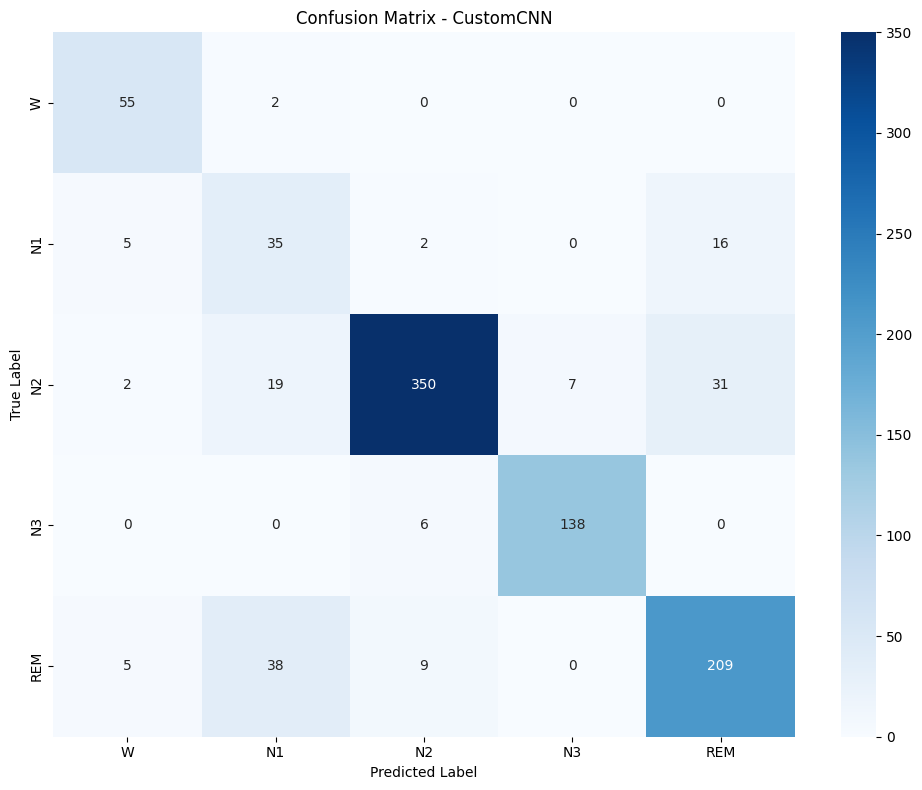

Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.93it/s]



Evaluation Results: ResNet18

Classification Report:
              precision    recall  f1-score   support

           W     0.5895    0.9825    0.7368        57
          N1     0.7143    0.0862    0.1538        58
          N2     0.9389    0.9389    0.9389       409
          N3     0.9577    0.9444    0.9510       144
         REM     0.8406    0.8889    0.8641       261

    accuracy                         0.8751       929
   macro avg     0.8082    0.7682    0.7289       929
weighted avg     0.8787    0.8751    0.8583       929


Confusion Matrix:
[[ 56   1   0   0   0]
 [ 17   5   7   0  29]
 [  4   0 384   6  15]
 [  0   0   8 136   0]
 [ 18   1  10   0 232]]

Cohen's Kappa Score: 0.8196
Overall Accuracy: 87.51%


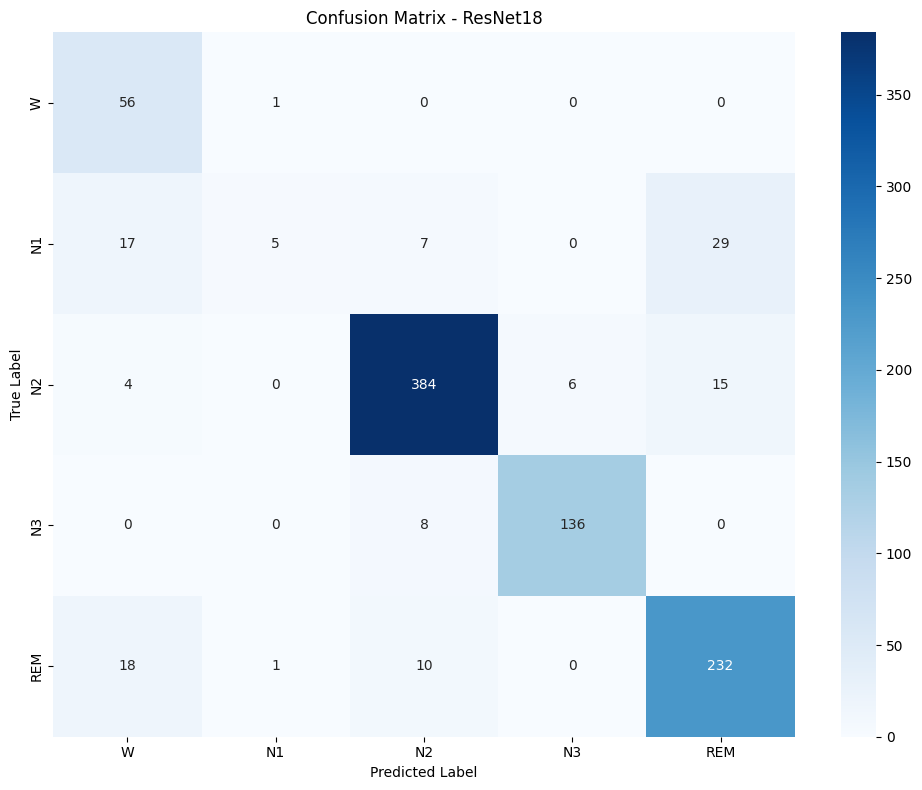

Evaluating: 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]



Evaluation Results: EfficientNet-B0

Classification Report:
              precision    recall  f1-score   support

           W     0.8361    0.8947    0.8644        57
          N1     0.2841    0.4310    0.3425        58
          N2     0.9744    0.8386    0.9014       409
          N3     0.8968    0.9653    0.9298       144
         REM     0.8352    0.8736    0.8539       261

    accuracy                         0.8461       929
   macro avg     0.7653    0.8006    0.7784       929
weighted avg     0.8717    0.8461    0.8553       929


Confusion Matrix:
[[ 51   6   0   0   0]
 [  4  25   0   0  29]
 [  3  31 343  16  16]
 [  0   0   5 139   0]
 [  3  26   4   0 228]]

Cohen's Kappa Score: 0.7847
Overall Accuracy: 84.61%


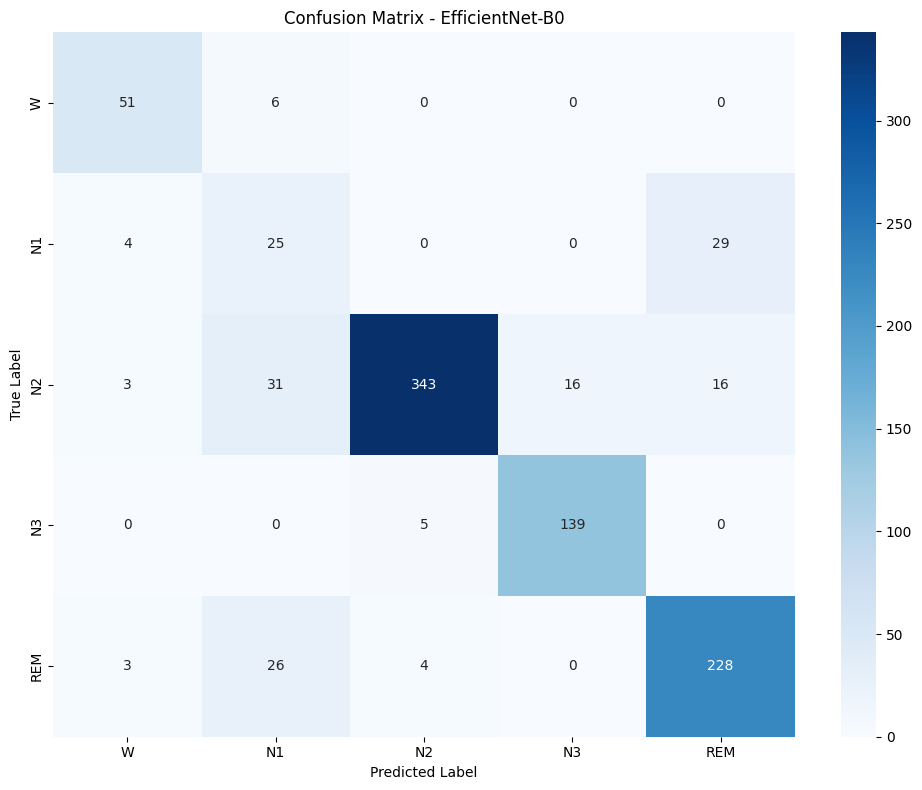

Evaluating: 100%|██████████| 30/30 [00:04<00:00,  6.87it/s]



Evaluation Results: MobileNetV2

Classification Report:
              precision    recall  f1-score   support

           W     0.7812    0.8772    0.8264        57
          N1     0.4737    0.1552    0.2338        58
          N2     0.8033    0.9584    0.8740       409
          N3     0.9852    0.9236    0.9534       144
         REM     0.8565    0.7318    0.7893       261

    accuracy                         0.8342       929
   macro avg     0.7800    0.7292    0.7354       929
weighted avg     0.8245    0.8342    0.8196       929


Confusion Matrix:
[[ 50   3   2   0   2]
 [  5   9  22   0  22]
 [  6   1 392   2   8]
 [  0   0  11 133   0]
 [  3   6  61   0 191]]

Cohen's Kappa Score: 0.7538
Overall Accuracy: 83.42%


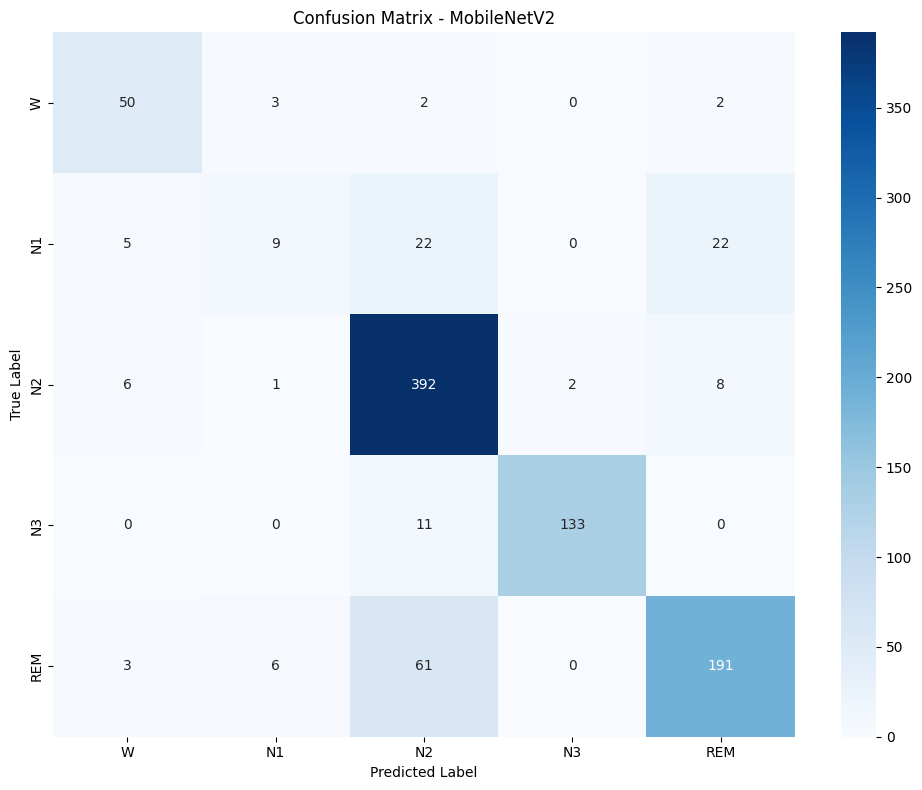

In [27]:
model_custom.load_state_dict(torch.load('/content/CustomCNN_best.pth'))
results_custom = evaluate_model(model_custom, test_loader, device, "CustomCNN")

model_resnet.load_state_dict(torch.load('/content/ResNet18_best.pth'))
results_resnet = evaluate_model(model_resnet, test_loader, device, "ResNet18")

model_efficientnet.load_state_dict(torch.load('/content/EfficientNet-B0_best.pth'))
results_effnet = evaluate_model(model_efficientnet, test_loader, device, "EfficientNet-B0")

model_mobilenet.load_state_dict(torch.load('/content/MobileNetV2_best.pth'))
results_mobile = evaluate_model(model_mobilenet, test_loader, device, "MobileNetV2")


MODEL COMPARISON
          Model  Best Val Acc  Test Acc  Cohen Kappa
      CustomCNN     84.714747 84.714747     0.785837
       ResNet18     87.513455 87.513455     0.819628
EfficientNet-B0     84.607104 84.607104     0.784661
    MobileNetV2     83.423036 83.423036     0.753783


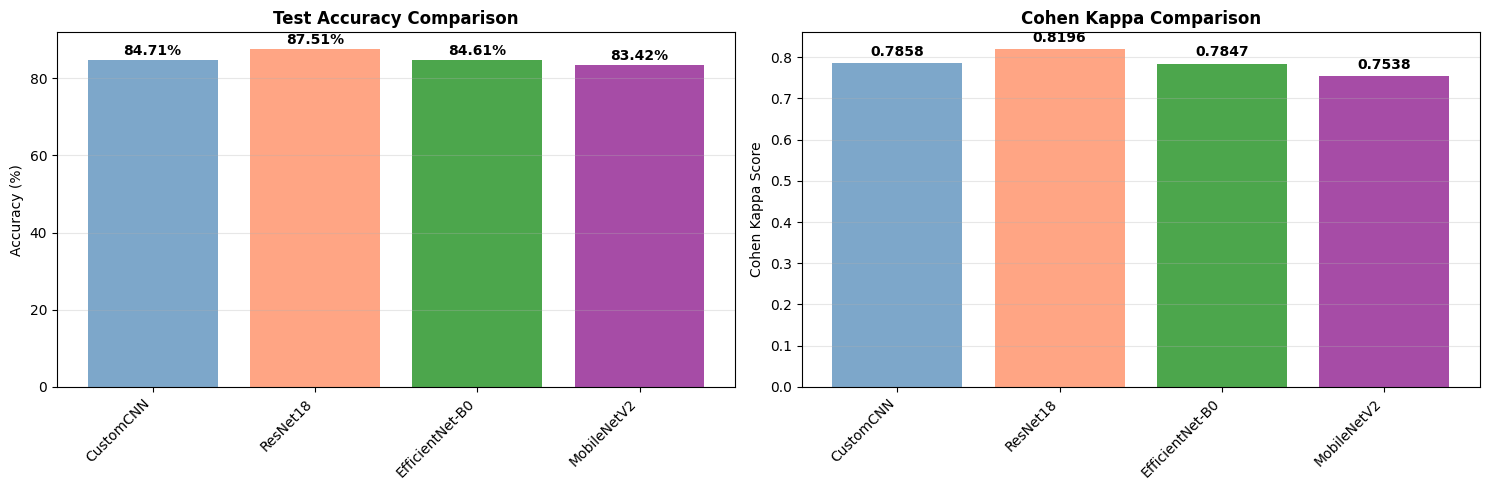


Best performing model: ResNet18
Test Accuracy: 87.51%
Cohen Kappa: 0.8196


In [28]:
comparison_df = pd.DataFrame({
    'Model': ['CustomCNN', 'ResNet18', 'EfficientNet-B0', 'MobileNetV2'],
    'Best Val Acc': [best_acc_custom, best_acc_resnet, best_acc_effnet, best_acc_mobile],
    'Test Acc': [results_custom['accuracy'], results_resnet['accuracy'],
                 results_effnet['accuracy'], results_mobile['accuracy']],
    'Cohen Kappa': [results_custom['kappa'], results_resnet['kappa'],
                    results_effnet['kappa'], results_mobile['kappa']]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos, comparison_df['Test Acc'], color=['steelblue', 'coral', 'green', 'purple'], alpha=0.7)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Test Accuracy Comparison', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Test Acc']):
    axes[0].text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontweight='bold')

axes[1].bar(x_pos, comparison_df['Cohen Kappa'], color=['steelblue', 'coral', 'green', 'purple'], alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].set_ylabel('Cohen Kappa Score')
axes[1].set_title('Cohen Kappa Comparison', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Cohen Kappa']):
    axes[1].text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/model_comparison.png', dpi=150)
plt.show()

best_model_idx = comparison_df['Test Acc'].idxmax()
best_model = comparison_df.iloc[best_model_idx]
print(f"\nBest performing model: {best_model['Model']}")
print(f"Test Accuracy: {best_model['Test Acc']:.2f}%")
print(f"Cohen Kappa: {best_model['Cohen Kappa']:.4f}")

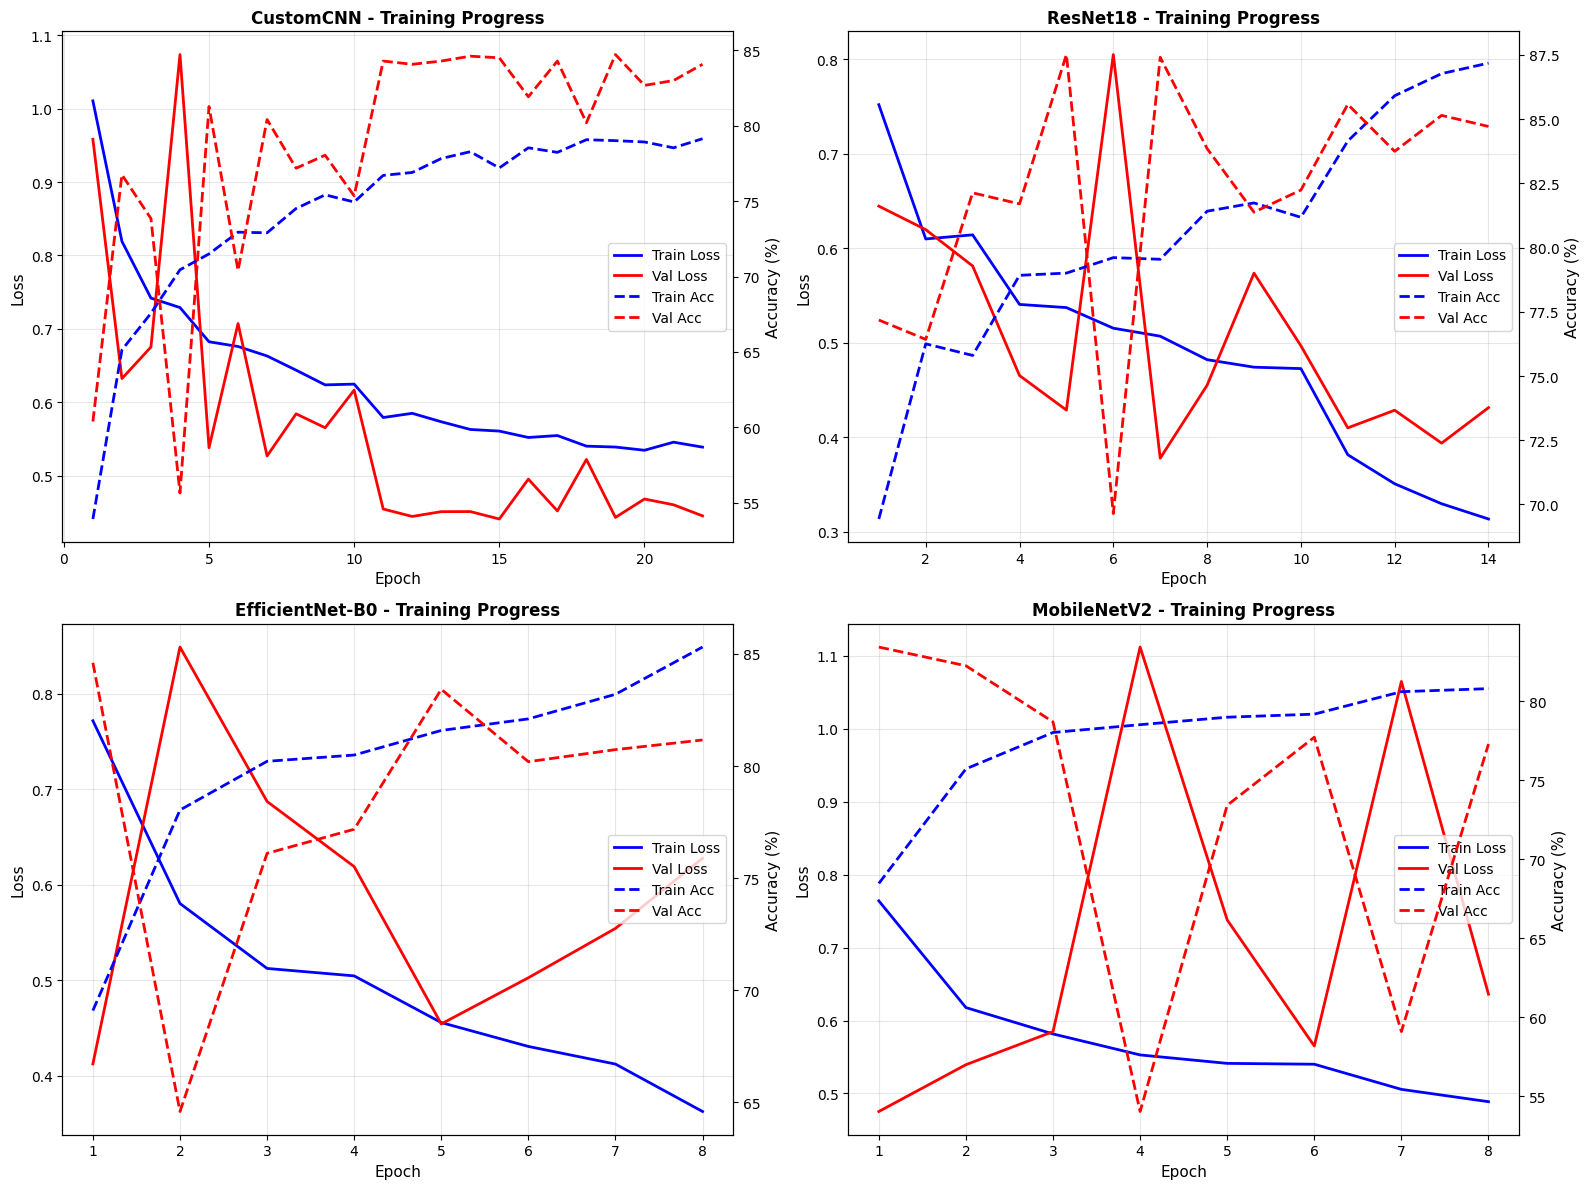

Training curves saved


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_data = [
    ('CustomCNN', train_hist_custom, val_hist_custom),
    ('ResNet18', train_hist_resnet, val_hist_resnet),
    ('EfficientNet-B0', train_hist_effnet, val_hist_effnet),
    ('MobileNetV2', train_hist_mobile, val_hist_mobile)
]

for idx, (name, train_hist, val_hist) in enumerate(models_data):
    row = idx // 2
    col = idx % 2

    ax = axes[row, col]
    epochs_range = range(1, len(train_hist['loss']) + 1)

    ax2 = ax.twinx()

    line1 = ax.plot(epochs_range, train_hist['loss'], 'b-', label='Train Loss', linewidth=2)
    line2 = ax.plot(epochs_range, val_hist['loss'], 'r-', label='Val Loss', linewidth=2)
    line3 = ax2.plot(epochs_range, train_hist['acc'], 'b--', label='Train Acc', linewidth=2)
    line4 = ax2.plot(epochs_range, val_hist['acc'], 'r--', label='Val Acc', linewidth=2)

    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11, color='black')
    ax2.set_ylabel('Accuracy (%)', fontsize=11, color='black')
    ax.set_title(f'{name} - Training Progress', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='center right')

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=150)
plt.show()

print("Training curves saved")